In [1]:
import ot
import sys

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr

from tqdm import trange

sys.path.append("../")
from lib_jax.estimator_entropy import ent
from lib_jax.gd import mirror_descent, gradient_descent
from lib_jax.utils_plot import plot_trajectory
from lib_jax.mirror_maps import EuclideanMirror

key = jr.key(42)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Utils Plot

In [2]:
def plot_particles(particles_gd, n_epochs, ax=None, n_plots=5, xmin=-1, xmax=1, ymin=-1, ymax=1):
    if ax is None:
        fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*3, 3))
    
    epochs = np.linspace(0, n_epochs, n_plots, dtype=int)
    
    for i, e in enumerate(epochs):
        particles = particles_gd[e] - jnp.mean(particles_gd[e], axis=0, keepdims=True)
        ax[i].scatter(particles[:,0], particles[:,1])
        ax[i].set_title("Epoch "+str(e))
        ax[i].set_xlim(xmin, xmax)
        ax[i].set_ylim(ymin, ymax)

### Well Conditioned Objective

Examples from [1]:

\begin{equation}
    W(z) = \frac{\|z\|_2^4}{4} - \frac{\|z\|_2^2}{2},
\end{equation}
and the functional is
\begin{equation}
    \mathcal{W}(\mu) = \frac12 \iint W(x-y)\ \mathrm{d}\mu(x)\mathrm{d}\mu(y).
\end{equation}

[1] Carrillo, J.A., Craig, K., Wang, L. and Wei, C., 2022. Primal dual methods for Wasserstein gradient flows. Foundations of Computational Mathematics, pp.1-55..

In [3]:
def W(x):
    # return jnp.sum(x**2, axis=-1) / 2
    norm_x2 = jnp.sum(x**2, axis=-1) # ** (1/2)
    return norm_x2**2 / 4 - norm_x2 / 2

def target(x, y):
    return jnp.mean(W(x[:,None]-y[None]))

@jax.jit
def sum_W(x):
    return jnp.sum(W(x))

grad_W = jax.jit(jax.grad(sum_W))

@jax.jit
def target_grad(x):
    C = x[None] - x[:,None]
    return jnp.mean(grad_W(C), axis=0)

In [4]:
n_epochs = 2000
lr = 0.01
n_particles = 1000
d = 2

x0 = 0.25 * np.random.randn(n_particles, d)

mirror_euc = EuclideanMirror()

particles_gd, grads_gd = mirror_descent(target_grad, mirror_euc,n_epochs, lr, x0=x0)

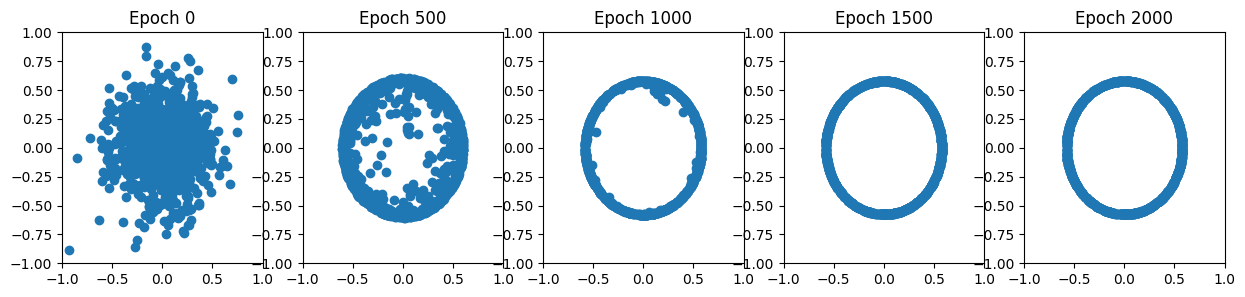

In [5]:
plot_particles(particles_gd, n_epochs)

In [6]:
L = []

for k in range(n_epochs):
    w = target(particles_gd[k], particles_gd[k])
    L.append(w)    

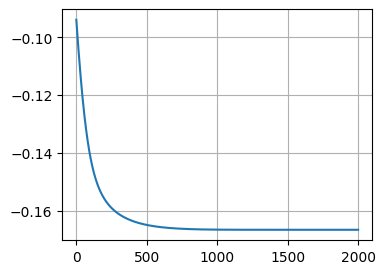

In [7]:
figure, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.plot(L)
plt.grid(True)
plt.show()

### Ill Conditioned Objective

Here,
\begin{equation}
    W(z) = \frac{(z^T\Sigma^{-1}z)^2}{4} - \frac{z^T\Sigma^{-1}z}{2}.
\end{equation}
We use as preconditioner $k(x)=\frac12 x^T \Sigma x$ (or Mirror map $\phi(x)=\frac12 x^T \Sigma^{-1} x$):
\begin{equation}
    T_{k+1} = \mathrm{Id} - \gamma \Sigma \nabla_{W_2}\mathcal{F}(\mu_k),
\end{equation}
where $\nabla_{W_2}\mathcal{F}(\mu_k) = \nabla W * \mu_k$.

In [8]:
Sigma_opt = np.array([[100.,0.],[.0,1]])
Sigma_opt_inv = jnp.linalg.inv(Sigma_opt)

In [9]:
def W(x):
    norm_x2 = jnp.einsum("nmi,ij,nmj -> nm", x, Sigma_opt_inv, x)
    return norm_x2**2 / 4 - norm_x2 / 2

def target(x, y):
    return jnp.mean(W(x[:,None]-y[None]))

@jax.jit
def sum_W(x):
    return jnp.sum(W(x))

grad_W = jax.jit(jax.grad(sum_W))

@jax.jit
def target_grad(x):
    C = x[None] - x[:,None]
    return jnp.mean(grad_W(C), axis=0)


@jax.jit
def precond_gaussian(x):
    return (Sigma_opt @ x.T).T

precond_grad = jax.jit(jax.grad(precond_gaussian))
precond_value_and_grad = jax.jit(jax.value_and_grad(precond_gaussian))

In [10]:
particles_gd, grads_gd = gradient_descent(target_grad, n_epochs, lr, n_particles, d, x0=x0)

particles_pgd, grads_pgd = gradient_descent(target_grad, n_epochs, lr, x0=x0,
                                            preconditioner=lambda x: precond_gaussian(x))

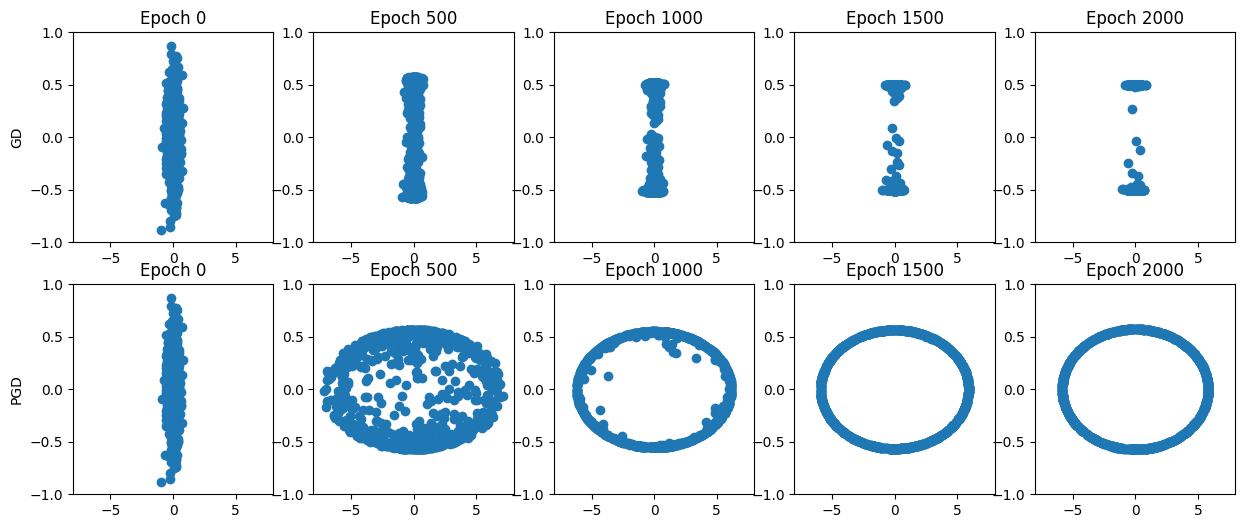

In [11]:
n_plots = 5
xmin, xmax, ymin, ymax = -8, 8, -1, 1

fig, ax = plt.subplots(2, n_plots, figsize=(n_plots*3, 2*3))

plot_particles(particles_gd, n_epochs, ax=ax[0], xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)
plot_particles(particles_pgd, n_epochs, ax=ax[1], xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)

ax[0,0].set_ylabel("GD")
ax[1,0].set_ylabel("PGD")

plt.show()

In [12]:
L_gd = []
L_pgd = []

for k in range(n_epochs):
    w = target(particles_gd[k], particles_gd[k])
    L_gd.append(w)  

    w = target(particles_pgd[k], particles_pgd[k])
    L_pgd.append(w)  

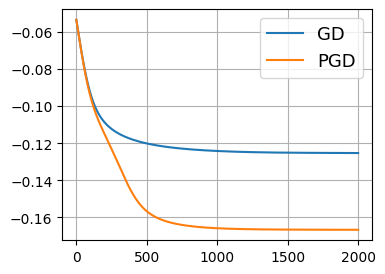

In [13]:
figure, ax = plt.subplots(1, 1, figsize=(4, 3))
plt.plot(L_gd, label="GD")
plt.plot(L_pgd, label="PGD")
plt.legend(fontsize=13)
plt.grid(True)
plt.show()